# Pooling Layer

After our initial convolutional layers as seen:

![q](cnn_img/q28.png)

We will need to a ***Pooling Layer** that will take a in a stack of feature maps. A complicated dataset with many categories is responsible for finding a pattern in the image. The more layers results in higher dimensionality and more parameters, thus leading to a high chance of overfitting. We need a method for reducing the dimensionality. There are two types of pooling layers: Max and Average


##  Max Pooling Layer

Takes a stack of feature maps as an input. The max pooling layer defines a window size (e.g 2x2 and a stride of 2) and uses it reduce the dimensionality even more. The algorithm simply takes the max within the 2x2 scan to condense the feature map. The result is a new feature map with half the size. 

![q](cnn_img/q30.png)


## Average Pooling Layer

It is worth noting that some architectures choose to use average pooling, which chooses to average pixel values in a given window size. So in a 2x2 window, this operation will see 4 pixel values, and return a single, average of those four values, as output!

This kind of pooling is typically not used for image classification problems because maxpooling is better at noticing the most important details about edges and other features in an image, but you may see this used in applications for which smoothing an image is preferable.

# Maxpooling Layer

In this notebook, we add and visualize the output of a maxpooling layer in a CNN. 

A convolutional layer + activation function, followed by a pooling layer, and a linear layer (to create a desired output size) make up the basic layers of a CNN.

<img src='cnn_img/CNN_all_layers.png' height=50% width=50% />

In [1]:
#imports
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

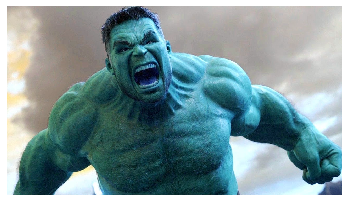

In [2]:
img = cv2.imread('cnn_img/hulk.jpg')
plt.imshow(img)
plt.axis('off')

gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray_img = gry.astype("float32")/255 # Normalize

### Define and visualize the filters

In [3]:
#Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], 
                        [-1, -1, 1, 1], 
                        [-1, -1, 1, 1], 
                        [-1, -1, 1, 1]])
print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [4]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)
print('Filter 2: \n', filter_2)
print('Filter 3: \n', filter_3)
print('Filter 4: \n', filter_4)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]
Filter 2: 
 [[ 1  1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]]
Filter 3: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]]
Filter 4: 
 [[ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]


### Define convolutional and pooling layers

You've seen how to define a convolutional layer, next is a:
* Pooling layer

In the next cell, we initialize a convolutional layer so that it contains all the created filters. Then add a maxpooling layer, [documented here](http://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html), with a kernel size of (2x2) so you can see that the image resolution has been reduced after this step!

A maxpooling layer reduces the x-y size of an input and only keeps the most *active* pixel values. Below is an example of a 2x2 pooling kernel, with a stride of 2, applied to a small patch of grayscale pixel values; reducing the size of the patch by a factor of 4. Only the maximum pixel values in 2x2 remain in the new, pooled output.

<img src='cnn_img/maxpooling_ex.png' height=50% width=50% />

In [5]:
class Model(nn.Module):
    
    def __init__(self, weight):
        super(Model, self).__init__()
        k_height, k_width = weight.shape[2:]
        # defines the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(1 ,4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        #define pooling layer
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x

In [6]:
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
print(weight)

model = Model(weight)
print(model)

tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]])
Model(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Visualize the output of each filter

First, we'll define a helper function, `viz_layer` that takes in a specific layer and number of filters (optional argument), and displays the output of that layer once an image has been passed through.

In [7]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Let's look at the output of a convolutional layer after a ReLu activation function is applied.

#### ReLU activation

A ReLU function turns all negative pixel values in 0's (black). See the equation pictured below for input pixel values, `x`. 

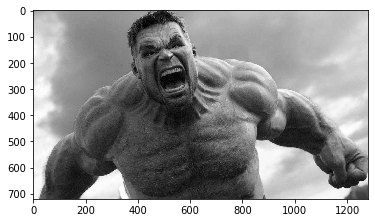

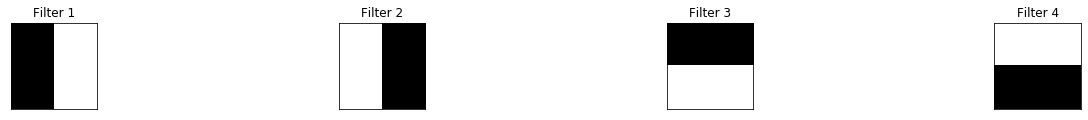

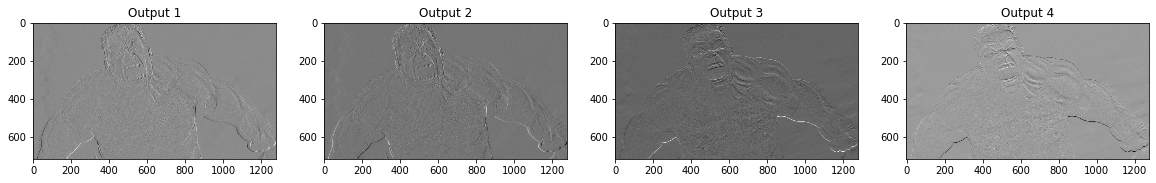

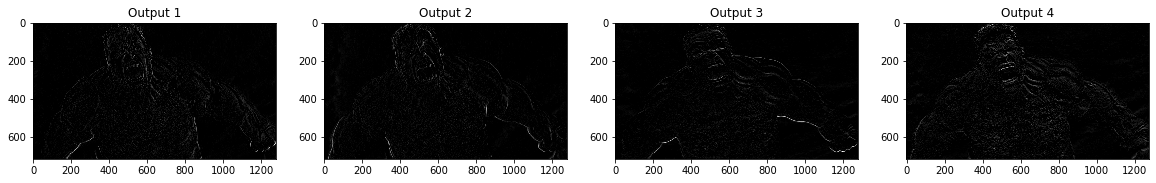

In [8]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(conv_layer)
viz_layer(activated_layer)

### Visualize the output of the pooling layer

Then, take a look at the output of a pooling layer. The pooling layer takes as input the feature maps pictured above and reduces the dimensionality of those maps, by some pooling factor, by constructing a new, smaller image of only the maximum (brightest) values in a given kernel area.

Take a look at the values on the x, y axes to see how the image has changed size.

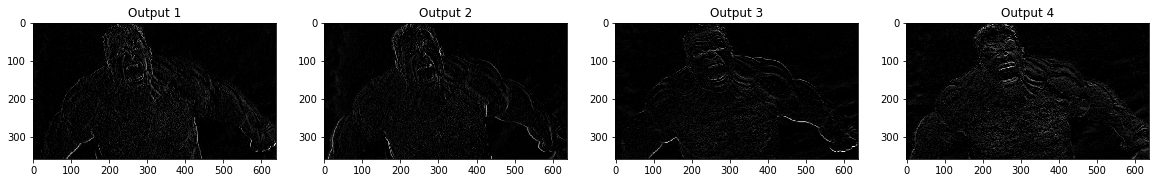

In [9]:
# visualize the output of the pooling layer
viz_layer(pooled_layer)

# Alternatives To Pooling

It's important to note that pooling operations do throw away some image information. That is, they discard pixel information in order to get a smaller, feature-level representation of an image. This works quite well in tasks like image classification, but it can cause some issues.

Consider the case of facial recognition. When you think of how you identify a face, you might think about noticing features; two eyes, a nose, and a mouth, for example. And those pieces, together, form a complete face! A typical CNN that is trained to do facial recognition, should also learn to identify these features. Only, by distilling an image into a feature-level representation, you might get a weird result:

Given an image of a face that has been photoshopped to include three eyes or a nose placed above the eyes, a feature-level representation will identify these features and still recognize a face! Even though that face is fake/contains too many features in an atypical orientation.

So, there has been research into classification methods that do not discard spatial information (as in the pooling layers), and instead learn to spatial relationships between parts (like between eyes, nose, and mouth).

One such method, for learning spatial relationships between parts, is the ***capsule network***.



# Capsule Networks
Capsule Networks provide a way to detect parts of objects in an image and represent spatial relationships between those parts. This means that capsule networks are able to recognize the same object, like a face, in a variety of different poses and with the typical number of features (eyes, nose , mouth) even if they have not seen that pose in training data.

Capsule networks are made of parent and child nodes that build up a complete picture of an object.

![q](cnn_img/q31.png)

In the example above, you can see how the parts of a face (eyes, nose, mouth, etc.) might be recognized in leaf nodes and then combined to form a more complete face part in parent nodes.

# What are Capsules?
Capsules are essentially a collection of nodes, each of which contains information about a specific part; part properties like width, orientation, color, and so on. The important thing to note is that each capsule outputs a vector with some magnitude and orientation.

Magnitude (m) = the probability that a part exists; a value between 0 and 1.

Orientation (theta) = the state of the part properties.

These output vectors allow us to do some powerful routing math to build up a parse tree that recognizes whole objects as comprised of several, smaller parts!

The magnitude is a special part property that should stay very high even when an object is in a different orientation, as shown below.

![q](cnn_img/q32.png)

![q](cnn_img/dynamic_routing.gif)

# Resources
You can learn more about [capsules, in this blog post](https://cezannec.github.io/Capsule_Networks/).
And experiment with an implementation of a capsule network in PyTorch, at this [github repo](https://github.com/cezannec/capsule_net_pytorch).